In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['repository']


In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [3]:
(train_x, train_y),(test_x, test_y) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)
train_x = train_x/255.0
test_x = test_x/255.0

In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape = (28, 28, 1), name='conv_1'))
model.add(BatchNormalization(name='batch_norm_1'))

model.add(Conv2D(64, (3,3), name='conv_2'))
model.add(BatchNormalization(name='batch_norm_2'))
model.add(MaxPooling2D(pool_size=(2,2), name='max_pool_1'))

model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu', name='dense_1'))
model.add(BatchNormalization(name='batch_norm_3'))

model.add(Dense(10, activation='softmax', name='dense_2'))

model.compile(loss= 'categorical_crossentropy' , optimizer= keras.optimizers.Adadelta(), metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
train = model.fit(train_x, keras.utils.to_categorical(train_y), batch_size=128, epochs=5, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 7s 156us/step - loss: 0.1595 - acc: 0.9533 - val_loss: 0.0779 - val_acc: 0.9760
Epoch 2/5
48000/48000 [==============================] - 4s 81us/step - loss: 0.0529 - acc: 0.9849 - val_loss: 0.0654 - val_acc: 0.9803
Epoch 3/5
48000/48000 [==============================] - 4s 80us/step - loss: 0.0290 - acc: 0.9921 - val_loss: 0.0504 - val_acc: 0.9841
Epoch 4/5
48000/48000 [==============================] - 4s 80us/step - loss: 0.0152 - acc: 0.9965 - val_loss: 0.0556 - val_acc: 0.9832
Epoch 5/5
48000/48000 [==============================] - 4s 81us/step - loss: 0.0079 - acc: 0.9986 - val_loss: 0.0475 - val_acc: 0.9861


In [7]:
model.save_weights('weights.h5')

In [8]:
new_model = Sequential()

new_model.add(Conv2D(32, kernel_size=(3,3), input_shape = (28, 28, 1), name='conv_1', trainable= False))
new_model.add(BatchNormalization(name='batch_norm_1', trainable= False))

new_model.add(Conv2D(64, (3,3), name='conv_2', trainable= False))
new_model.add(BatchNormalization(name='batch_norm_2', trainable= False))
new_model.add(MaxPooling2D(pool_size=(2,2), name='max_pool_1', trainable= False))

new_model.add(Flatten())
new_model.add(Dense(128, activation='relu', name='dense_1', trainable= False))
new_model.add(BatchNormalization(name='batch_norm_3', trainable= False))

new_model.add(Dense(10, activation='softmax', name='dense_2'))

new_model.compile(loss= 'categorical_crossentropy' , optimizer= keras.optimizers.Adadelta(), metrics=['accuracy'])

In [9]:
new_model.load_weights('weights.h5', by_name=True)

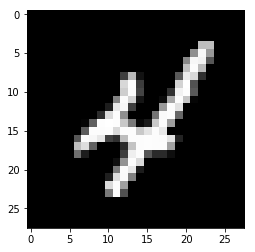

In [10]:
plt.imshow(train_x[9].reshape(28, 28),cmap='gray', vmin=0, vmax=1 )

In [11]:
def preprocess_img(img):
    image = cv2.copyMakeBorder(img.reshape(28,28),5,5,5,5,cv2.BORDER_CONSTANT,value=[255,255,255])
    image = cv2.resize(image, (28, 28))
    ret,image = cv2.threshold(image,0.85,1,cv2.THRESH_BINARY_INV) 
    image = np.expand_dims(image, 0)
    image = np.expand_dims(image, -1)
    return image

In [12]:
import cv2
from keras.preprocessing.image import ImageDataGenerator

def preprocess_img(img):
    image = cv2.copyMakeBorder(img.reshape(28,28),5,5,5,5,cv2.BORDER_CONSTANT,value=[255,255,255])
    image = cv2.resize(image, (28, 28))
    ret,image = cv2.threshold(image,0.85,1,cv2.THRESH_BINARY_INV) 
    image = np.expand_dims(image, 0)
    image = np.expand_dims(image, -1)
    return image

datagen = ImageDataGenerator(
    rescale = 1. /255,
    data_format = 'channels_last',
    preprocessing_function = preprocess_img #this statement perhaps could be creating the anomaly)

train_generator = datagen.flow_from_directory('../input/repository/subhrajyotidasgupta-barc_projects-4b267ca/Numeral/train',
                                                   target_size = (28,28),
                                                   batch_size = 8,
                                                   color_mode = 'grayscale',
                                                   class_mode = 'categorical')

valid_generator = datagen.flow_from_directory('../input/repository/subhrajyotidasgupta-barc_projects-4b267ca/Numeral/valid',
                                                   target_size = (28,28),
                                                   batch_size = 8,
                                                   color_mode = 'grayscale',
                                                   class_mode = 'categorical')

Found 106 images belonging to 10 classes.
Found 28 images belonging to 10 classes.


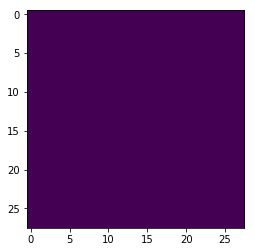

In [15]:
plt.imshow(train_generator[0][0][0].reshape(28,28))
#preprocess_img(valid_generator[0][0][0]).shape
#train_generator[0][0][0].shape
#plt.imshow(preprocess_img(train_generator[0][0][0]).reshape(28,28))
#print(train_generator[0][0][0].reshape(28,28))

In [20]:
new_model.fit_generator(train_generator,
                       validation_data = valid_generator,
                       validation_steps = 4096,
                       epochs = 10,
                       steps_per_epoch = 2)

Epoch 1/10
2/2 [==============================] - 30s 15s/step - loss: 2.2410 - acc: 0.1250 - val_loss: 11.7434 - val_acc: 0.1072
Epoch 2/10
2/2 [==============================] - 31s 15s/step - loss: 2.3494 - acc: 0.0625 - val_loss: 11.6997 - val_acc: 0.1071
Epoch 3/10
2/2 [==============================] - 31s 15s/step - loss: 2.2283 - acc: 0.0625 - val_loss: 11.7184 - val_acc: 0.1072
Epoch 4/10
2/2 [==============================] - 31s 16s/step - loss: 2.2768 - acc: 0.2750 - val_loss: 11.6412 - val_acc: 0.1071
Epoch 5/10
2/2 [==============================] - 31s 15s/step - loss: 2.3581 - acc: 0.1250 - val_loss: 11.6358 - val_acc: 0.1072
Epoch 6/10
1/2 [==============>...............] - ETA: 0s - loss: 2.3360 - acc: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
import cv2 

fig = plt.figure(figsize=(20,20))
for i in range(1,11):
    img = cv2.copyMakeBorder(train_generator[i][0][0].reshape(28,28),5,5,5,5,cv2.BORDER_CONSTANT,value=[255,255,255])
    img = cv2.resize(img, (28, 28))
    ret,img = cv2.threshold(img,0.85,1,cv2.THRESH_BINARY_INV) 
    #kernel = np.ones((2,2), np.uint8) 
    #img = cv2.dilate(img, kernel, iterations=1)
    
    fig.add_subplot(7,5,i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    #print(img)
    img = np.expand_dims(img, 0)
    img = np.expand_dims(img, -1)

    
    train_preds = new_model.predict(img)
    plt.title("Prediction = " + str(np.argmax(train_preds)))
plt.show()